In [45]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pylab as plt
import warnings
import pickle
import cv2
import torch.nn as nn
import random

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
data = pd.read_csv("annotations.csv")

In [21]:
data.head()

,image,class
0,images/p7FhNESI-2TX5-aXiT-9nNv-f7LJlzc9BgqO.jpg,artificial_roughness
1,images/XJV2G0zl-scMm-HsbL-ovdy-J4mvzVQBO5uF.jpg,artificial_roughness
2,images/Yp1H0brV-VXZB-SZTa-PcFZ-Nes25RWxLgM4.jpg,artificial_roughness
3,images/VhuQ8Uqi-XxbK-TJwS-j5RN-ApJqVTBg0lbZ.jpg,artificial_roughness
4,images/LudjvYTM-V03e-BeaZ-6Sfj-bpeRzYmtG8Ew.jpg,artificial_roughness


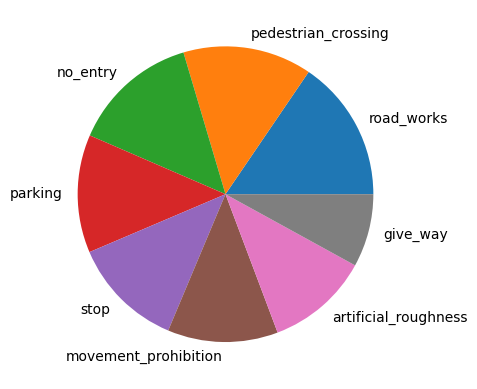

In [22]:
plt.pie(data["class"].value_counts(), labels=data["class"].value_counts().index);

In [7]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
DATA_MODES = ['train', 'val']
RESCALE_SIZE = 50
BATCH_SIZE = 128

DEVICE = torch.device("cuda")

In [9]:
# with open("data.bf", "wb") as file:
#   pickle.dump(images, file)
with open("data.bf", "rb") as file:
  images = pickle.load(file)

In [10]:
images = np.array(images)
images.shape

<ipython-input-10-1aeedb4632c8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


(2014,)

In [13]:
for i in tqdm(range(len(images))):
  images[i] = cv2.resize(images[i], (50, 50))

100%|██████████| 2014/2014 [00:00<00:00, 42224.82it/s]


In [14]:
images = np.array(list(images))
images.shape

(2014, 50, 50, 3)

In [ ]:
import cv2
img = cv2.imread("drive/MyDrive/" + "images/ngT0ipJE-biuj-d81S-UoZW-iAGFEPdJcsV0.jpg")
print(img.shape)

(43, 50, 3)


In [119]:
class ImagesDataset(Dataset):
    def __init__(self, files, mode, images_labels):
        super().__init__()
        self.files = files
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = images_labels
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', '+wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        return images[file]

    def __getitem__(self, index):
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

            ])
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = transform(self.files[index])
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [120]:
def imshow(inp, title=None, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [121]:
labels = []
for i in tqdm(data.values):
  # images.append(cv2.imread("drive/MyDrive/" + i[0]))
  labels.append(i[1])

100%|██████████| 2014/2014 [00:00<00:00, 738661.09it/s]


In [122]:
class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

In [123]:
class SVHNPolicy(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](Image.fromarray(img))

In [124]:
class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [151]:
policy = SVHNPolicy()
img_data_train = images.copy()
imgs = img_data_train
lbl_data_train = labels.copy()
lbls = lbl_data_train
for i in range(20):
    img_data_train = np.concatenate((img_data_train, np.array(list(map(lambda x: np.asarray(policy(x)), imgs))).astype('uint8')))
    lbl_data_train = np.concatenate((lbl_data_train, lbls))
    print(len(lbl_data_train), img_data_train.shape)

4028 (4028, 50, 50, 3)
6042 (6042, 50, 50, 3)
8056 (8056, 50, 50, 3)
10070 (10070, 50, 50, 3)
12084 (12084, 50, 50, 3)
14098 (14098, 50, 50, 3)
16112 (16112, 50, 50, 3)
18126 (18126, 50, 50, 3)
20140 (20140, 50, 50, 3)
22154 (22154, 50, 50, 3)
24168 (24168, 50, 50, 3)
26182 (26182, 50, 50, 3)
28196 (28196, 50, 50, 3)
30210 (30210, 50, 50, 3)
32224 (32224, 50, 50, 3)
34238 (34238, 50, 50, 3)
36252 (36252, 50, 50, 3)
38266 (38266, 50, 50, 3)
40280 (40280, 50, 50, 3)
42294 (42294, 50, 50, 3)


In [152]:
from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(
    img_data_train, lbl_data_train, test_size=0.15, stratify=lbl_data_train
)
# train_files, val_files = train_val_files[:-1], [train_val_files[-1]]

In [153]:
val_files.shape, val_labels.shape

((6345, 50, 50, 3), (6345,))

In [154]:
val_dataset = ImagesDataset(
    val_files, mode='val',
    images_labels=val_labels
)

In [155]:
len(val_dataset)

6345

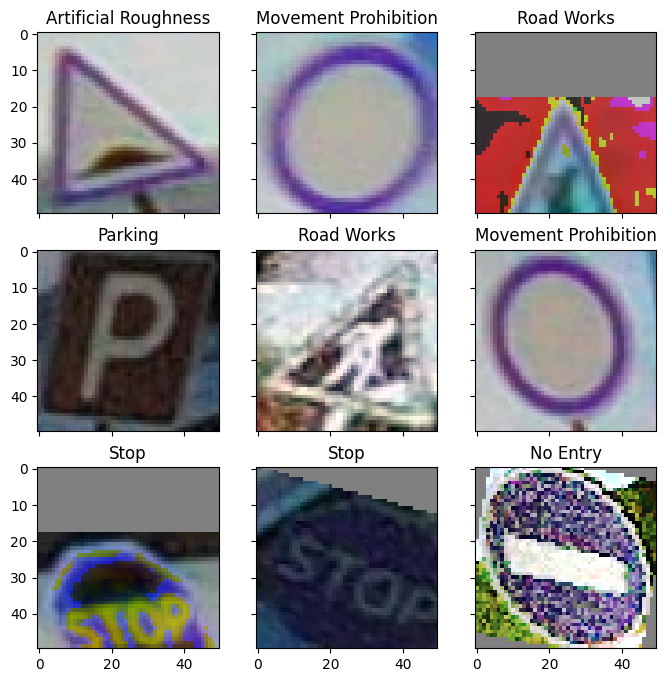

In [156]:

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
          title=img_label,plt_ax=fig_x)

In [157]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.nn.functional.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    # scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [158]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data, dtype=torch.float32)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [159]:

def train(train_data, val_data, model, epochs, batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.0005)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler=scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [160]:

def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [161]:
n_classes = len(np.unique(labels))

In [162]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=1),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
        )
        self.flat = nn.Flatten()
        self.out = nn.Sequential(
            nn.Linear(96, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.Linear(24, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        # print(x.shape)
        x = self.flat(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [163]:
n_classes = len(np.unique(labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :8
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [164]:
if val_dataset is None:
    val_dataset = ImagesDataset(val_files, mode='val', images_labels=val_labels)

train_dataset = ImagesDataset(train_files, mode='train', images_labels=train_labels)

In [165]:
import warnings
warnings.filterwarnings("ignore")


In [166]:
len(train_dataset)

35949

In [167]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=19, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/19 [00:00<?, ?it/s]

loss 0.795848664125649


epoch:   5%|▌         | 1/19 [00:20<06:09, 20.53s/it]


Epoch 001 train_loss: 0.7958     val_loss 0.2971 train_acc 0.7763 val_acc 0.9344
loss 0.17710081106090403


epoch:  11%|█         | 2/19 [00:40<05:46, 20.37s/it]


Epoch 002 train_loss: 0.1771     val_loss 0.1090 train_acc 0.9429 val_acc 0.9630
loss 0.09177346627452238


epoch:  16%|█▌        | 3/19 [01:01<05:27, 20.44s/it]


Epoch 003 train_loss: 0.0918     val_loss 0.1119 train_acc 0.9697 val_acc 0.9642
loss 0.05731224688105502


epoch:  21%|██        | 4/19 [01:21<05:06, 20.44s/it]


Epoch 004 train_loss: 0.0573     val_loss 0.0722 train_acc 0.9810 val_acc 0.9781
loss 0.0446966210467606


epoch:  26%|██▋       | 5/19 [01:42<04:47, 20.51s/it]


Epoch 005 train_loss: 0.0447     val_loss 0.0829 train_acc 0.9840 val_acc 0.9738
loss 0.03094017593441214


epoch:  32%|███▏      | 6/19 [02:03<04:27, 20.57s/it]


Epoch 006 train_loss: 0.0309     val_loss 0.0634 train_acc 0.9898 val_acc 0.9801
loss 0.02169024979189537


epoch:  37%|███▋      | 7/19 [02:23<04:08, 20.67s/it]


Epoch 007 train_loss: 0.0217     val_loss 0.0570 train_acc 0.9923 val_acc 0.9838
loss 0.018214880774512814


epoch:  42%|████▏     | 8/19 [02:44<03:47, 20.65s/it]


Epoch 008 train_loss: 0.0182     val_loss 0.0807 train_acc 0.9940 val_acc 0.9786
loss 0.010998954361614693


epoch:  47%|████▋     | 9/19 [03:05<03:27, 20.72s/it]


Epoch 009 train_loss: 0.0110     val_loss 0.0513 train_acc 0.9962 val_acc 0.9871
loss 0.027833276408534825


epoch:  53%|█████▎    | 10/19 [03:26<03:07, 20.80s/it]


Epoch 010 train_loss: 0.0278     val_loss 0.0691 train_acc 0.9903 val_acc 0.9830
loss 0.013781448057475094


epoch:  58%|█████▊    | 11/19 [03:47<02:46, 20.76s/it]


Epoch 011 train_loss: 0.0138     val_loss 0.0801 train_acc 0.9955 val_acc 0.9792
loss 0.025345513053969378


epoch:  63%|██████▎   | 12/19 [04:07<02:25, 20.75s/it]


Epoch 012 train_loss: 0.0253     val_loss 0.0825 train_acc 0.9918 val_acc 0.9792
loss 0.009445356424503764


epoch:  68%|██████▊   | 13/19 [04:28<02:05, 20.87s/it]


Epoch 013 train_loss: 0.0094     val_loss 0.0560 train_acc 0.9973 val_acc 0.9857
loss 0.0029787621207934068


epoch:  74%|███████▎  | 14/19 [04:49<01:44, 20.89s/it]


Epoch 014 train_loss: 0.0030     val_loss 0.0460 train_acc 0.9993 val_acc 0.9891
loss 0.0006969329051432654


epoch:  79%|███████▉  | 15/19 [05:10<01:23, 20.83s/it]


Epoch 015 train_loss: 0.0007     val_loss 0.0454 train_acc 0.9999 val_acc 0.9893
loss 0.00048404094708984945


epoch:  84%|████████▍ | 16/19 [05:30<01:02, 20.69s/it]


Epoch 016 train_loss: 0.0005     val_loss 0.0410 train_acc 0.9999 val_acc 0.9902
loss 0.0006389112234767454


epoch:  89%|████████▉ | 17/19 [05:51<00:41, 20.58s/it]


Epoch 017 train_loss: 0.0006     val_loss 0.0507 train_acc 0.9998 val_acc 0.9871
loss 0.0008821092837919681


epoch:  95%|█████████▍| 18/19 [06:11<00:20, 20.52s/it]


Epoch 018 train_loss: 0.0009     val_loss 0.0447 train_acc 0.9998 val_acc 0.9907
loss 0.00017175962833100214


epoch: 100%|██████████| 19/19 [06:32<00:00, 20.63s/it]


Epoch 019 train_loss: 0.0002     val_loss 0.0417 train_acc 1.0000 val_acc 0.9916


In [168]:
torch.save(
    simple_cnn.state_dict(), 'model.pth'
)

In [169]:
loss, acc, val_loss, val_acc = zip(*history)

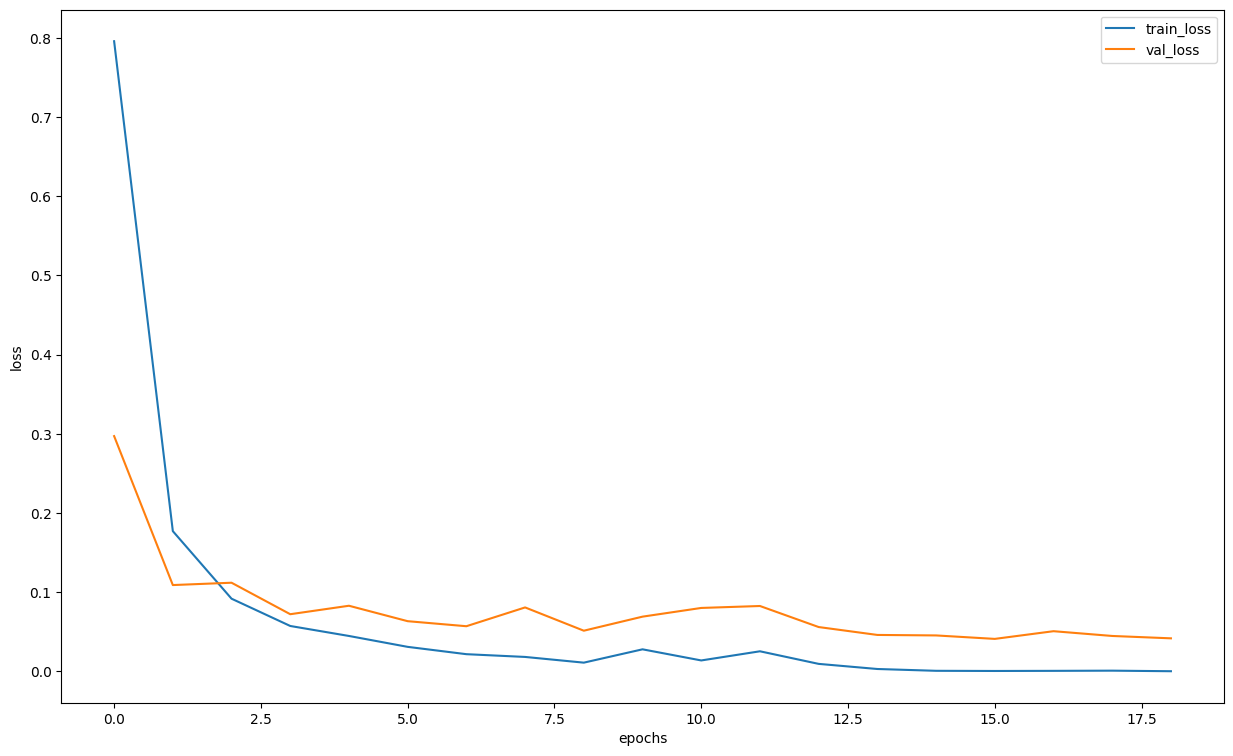

In [170]:

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [171]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [172]:

idxs = list(map(int, np.arange(0,len(train_dataset))))
imgs = [train_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [173]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [174]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [train_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [175]:
from sklearn.metrics import classification_report

print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4052
           1       1.00      1.00      1.00      2874
           2       1.00      1.00      1.00      4337
           3       1.00      1.00      1.00      4998
           4       1.00      1.00      1.00      4641
           5       1.00      1.00      1.00      5069
           6       1.00      1.00      1.00      5569
           7       1.00      1.00      1.00      4409

    accuracy                           1.00     35949
   macro avg       1.00      1.00      1.00     35949
weighted avg       1.00      1.00      1.00     35949



In [176]:
n_classes

8

In [177]:
val_dataset[0]

(tensor([[[-1.1418, -1.2788, -1.3302,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.1529,  0.2282, -0.3027,  ...,  2.2489,  2.1633,  2.1633],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.0434,  1.9407,  1.7865],
          ...,
          [-1.6727, -1.6042, -1.4158,  ..., -0.1999,  0.0741, -0.0801],
          [-1.6042, -1.4672, -1.3302,  ...,  0.0741, -0.1999, -0.6452],
          [-1.8953, -1.5870, -1.3302,  ..., -0.4739, -0.6965, -0.7822]],
 
         [[-1.3880, -1.5105, -1.5455,  ...,  2.2360,  2.2360,  2.2360],
          [-0.1625, -0.3550, -0.5126,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-1.5105, -1.4230, -1.2479,  ..., -0.0924, -0.0924, -0.0924],
          [-1.3529, -1.1954, -1.0903,  ...,  0.1001, -0.0224, -0.3375],
          [-1.3880, -1.0378, -0.8978,  ..., -0.0224, -0.2325, -0.2850]],
 
         [[ 1.7511,  1.3677,  0.5659,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.5354,  2.4308,